In [43]:
# Imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


PROJECT_ROOT = Path("..").resolve()
PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "amazon_sales_regression.csv"

SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

In [6]:
df_model = pd.read_csv(PROCESSED_PATH)

df_model.head()

,Category,Brand,Quantity,UnitPrice,Discount,Tax,ShippingCost,TotalAmount,PaymentMethod,OrderStatus,City,State,Country,OrderYear,OrderMonth,OrderDayOfWeek
0,Books,BrightLux,3,106.59,0.00,0.00,0.09,319.86,Debit Card,Delivered,Washington,DC,India,2023,1,Tuesday
1,Home & Kitchen,UrbanStyle,1,251.37,0.05,19.10,1.74,259.64,Amazon Pay,Delivered,Fort Worth,TX,United States,2023,12,Saturday
2,Clothing,UrbanStyle,3,35.03,0.10,7.57,5.91,108.06,Debit Card,Delivered,Austin,TX,United States,2022,5,Tuesday
3,Home & Kitchen,Zenith,5,33.58,0.15,11.42,5.53,159.66,Cash on Delivery,Delivered,Charlotte,NC,India,2023,7,Tuesday
4,Clothing,KiddoFun,2,515.64,0.25,38.67,9.23,821.36,Credit Card,Cancelled,San Antonio,TX,Canada,2023,2,Saturday


In [7]:
df_model.tail()

,Category,Brand,Quantity,UnitPrice,Discount,Tax,ShippingCost,TotalAmount,PaymentMethod,OrderStatus,City,State,Country,OrderYear,OrderMonth,OrderDayOfWeek
99995,Electronics,Apex,2,492.34,0.00,78.77,2.75,1066.20,UPI,Delivered,Jacksonville,FL,India,2023,3,Tuesday
99996,Sports & Outdoors,Apex,5,449.30,0.00,179.72,6.07,2432.29,Credit Card,Delivered,San Jose,CA,United States,2021,11,Wednesday
99997,Sports & Outdoors,BrightLux,4,232.40,0.00,74.37,12.43,1016.40,Cash on Delivery,Delivered,Indianapolis,IN,United States,2023,4,Saturday
99998,Sports & Outdoors,HomeEase,1,294.05,0.00,23.52,13.09,330.66,Debit Card,Delivered,Charlotte,NC,United States,2021,11,Monday
99999,Home & Kitchen,CoreTech,5,166.70,0.05,63.35,3.34,858.52,Debit Card,Delivered,New York,NY,United States,2021,12,Saturday


In [8]:
# Check dtypes
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Category        100000 non-null  object 
 1   Brand           100000 non-null  object 
 2   Quantity        100000 non-null  int64  
 3   UnitPrice       100000 non-null  float64
 4   Discount        100000 non-null  float64
 5   Tax             100000 non-null  float64
 6   ShippingCost    100000 non-null  float64
 7   TotalAmount     100000 non-null  float64
 8   PaymentMethod   100000 non-null  object 
 9   OrderStatus     100000 non-null  object 
 10  City            100000 non-null  object 
 11  State           100000 non-null  object 
 12  Country         100000 non-null  object 
 13  OrderYear       100000 non-null  int64  
 14  OrderMonth      100000 non-null  int64  
 15  OrderDayOfWeek  100000 non-null  object 
dtypes: float64(5), int64(3), object(8)
memory usage: 12.2+ MB

In [9]:
# Define Feature List
TARGET_COL = "TotalAmount"

# Separate feature names by dtype
all_features = df_model.columns.drop(TARGET_COL)

numeric_features = df_model[all_features].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df_model[all_features].select_dtypes(include=["object"]).columns.tolist()

numeric_features, categorical_features

(['Quantity',
  'UnitPrice',
  'Discount',
  'Tax',
  'ShippingCost',
  'OrderYear',
  'OrderMonth'],
 ['Category',
  'Brand',
  'PaymentMethod',
  'OrderStatus',
  'City',
  'State',
  'Country',
  'OrderDayOfWeek'])

I will feed these features into `ColumnTransformer` later. ColumnTransformer is standard for mixed-type datasets.

In [10]:
# Preparing train and test split

X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)


(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((80000, 15), (20000, 15)), ((80000,), (20000,)))

### Reusable evaluation 

Now, I will create a reusable model evaluation helper.

In [11]:
def evaluate_regression(y_true, y_pred):
    """
    Compute MAE, MSE, RMSE, R2_score and return them as a dict.

    y_true: array-like of shape (n_samples,)
    y_pred: array-like of shape (n_samples, )
    """

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
    }



### Baseline model

I will use `DummyRegressor` from scikit-learn that designed to give a simple baseline by using trivial prediction rules. 

Real models must beat this baseline, otherwise it means that I've done something wrong.

In [12]:
# Dummy Regressor

# strategy="mean" -> always predict mean (y_train)
dummy_reg = DummyRegressor(strategy="mean")

dummy_reg.fit(X_train, y_train)   # X_train is ignored, it only uses y_train internally. Because dummy regressor is designed as a baseline that ignores all features and predicts a constant value.
y_pred_dummy = dummy_reg.predict(X_test)

dummy_metrics = evaluate_regression(y_test, y_pred_dummy)
dummy_metrics

{'MAE': 590.7305084322625,
 'MSE': 520888.6810560011,
 'RMSE': np.float64(721.7261814954485),
 'R2': -4.454500623718438e-05}

PS: Other strategies exist like median, quantile, constant but I'm using `mean` because it's standard.

---

## Preprocessing pipeline

I will buil a real baseline model. I want to handle mixed types:

- one hot encode categorical features
- optionally scale numeric features

Then train a `LinearRegression` model on top of those transformed features. 

In [13]:
# Preprocessing for numeric columns -> standarization
numeric_transformer = StandardScaler()

# Preprocessing for categorical columns -> one-hot encoding
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=True
)

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# Full pipeline -> preprocessing + linear regression
linreg_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]
)

In [14]:
# Train and evaluate LinearRegression pipeline
linreg_model.fit(X_train, y_train)

y_pred_linreg_train = linreg_model.predict(X_train)
y_pred_linreg_test = linreg_model.predict(X_test)

linreg_metrics_train = evaluate_regression(y_train, y_pred_linreg_train)
linreg_metrics_test = evaluate_regression(y_test, y_pred_linreg_test)

linreg_metrics_train, linreg_metrics_test

({'MAE': 165.43873208505107,
  'MSE': 47191.058255364645,
  'RMSE': np.float64(217.23502999140044),
  'R2': 0.9102682891399962},
 {'MAE': 166.0903634638342,
  'MSE': 47174.249821508965,
  'RMSE': np.float64(217.19633933726638),
  'R2': 0.9094310302479206})

### My Interpretation

Compare to DummyRegressor:

1. MAE =~ 590
2. RMSE =~ 722
3. R2 =~ 0 (negative)

LinearRegression:

1. MAE dropped from 590 to 166 (3.5x smaller error on average)
2. RMSE dropped from 722 to 217 (3.3x smaller)
3. R2 jumped from ~0 to 0.91

I've noticed that r2 is 0.91 that means the model explains about 91% of the variance in `TotalAmount` compared to dummy baseline (median baseline). That's very high for a regression problem, specifically on noisy real-world data. 

In my opinion, this dataset is synthetic and `TotalAmount` is a function of things like Quantity, UnitPrice, Discount, Tax and ShippingCost, it makes senese that a linaer model with the right features can get very high R2.

`Conclusion:` LinearRegression model definitely beat the dummy baseline (always predict mean). That's exactly what I wanted.


### Checking for overfitting

- Train MAE ~165.5 vs Test MAE ~166.1
- Train RMSE ~217.2 vs Test RMSE ~217.2
- Train R2 0.91 vs Test R2 0.90

These are almost identical. And I can understand that train and test metrics are extremely close (R² 0.91 vs 0.90), indicating good generalization and no significant overfitting for this baseline linear model.

PS: The high R2 and similar train/test performance imply that `TotalAmount` is strongly determined by features (specifically the numeric pricing fields) and relationships are close to linaer, or at least linear plus one-hot captures them well. Also, the dataset is clean with low noise (no problematic outliers messing up the model).

In [15]:
from amazon_sales_ml.models.pipelines import get_pipeline, get_param_grid

def run_model_grid_search(
    model_name: str,
    X_train,
    y_train,
    scoring: str = "neg_mean_absolute_error",
    cv: int = 2,
):
    """Run grid search for a given model name"""
    pipeline = get_pipeline(model_name, numeric_features, categorical_features)
    param_grid = get_param_grid(model_name)

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2,
        return_train_score=True,
    )

    grid.fit(X_train, y_train)
    return grid


In [16]:
# Train the models

# Random Forest
rf_grid = run_model_grid_search("random_forest", X_train, y_train)

rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_
rf_best_cv_rmse = -rf_grid.best_score_

y_pred_rf_train = rf_best_model.predict(X_train)
y_pred_rf_test = rf_best_model.predict(X_test)

rf_metrics_train = evaluate_regression(y_train, y_pred_rf_train)
rf_metrics_test = evaluate_regression(y_test, y_pred_rf_test)

rf_best_params, rf_best_cv_rmse, rf_metrics_test


# HistGradientBoostingRegressor
hgb_grid = run_model_grid_search("hist_gb", X_train, y_train)


# XGBRegressor
xgb_grid = run_model_grid_search("xgboost", X_train, y_train)

# LightGBM
#lgbm_grid = run_model_grid_search("lightgbm", X_train, y_train)



Fitting 2 folds for each of 2 candidates, totalling 4 fits


[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4.0s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   5.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   7.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.0s
Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  13.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=  12.9s
[CV] END model__learning_rate=0.05, model__max_depth=None, mo

In [17]:
rf_best_model

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
rf_best_params


{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [19]:
rf_best_cv_rmse

np.float64(109.95749043749998)

In [20]:
rf_metrics_test

{'MAE': 94.316331905,
 'MSE': 16964.243236365877,
 'RMSE': np.float64(130.2468549960646),
 'R2': 0.9674306631614774}

In [21]:
# ==== HistGradientBoostingRegressor ====
hgb_best_model = hgb_grid.best_estimator_
hgb_best_params = hgb_grid.best_params_
hgb_best_cv_rmse = -hgb_grid.best_score_  # flip sign from neg RMSE

y_pred_hgb_train = hgb_best_model.predict(X_train)
y_pred_hgb_test = hgb_best_model.predict(X_test)

hgb_metrics_train = evaluate_regression(y_train, y_pred_hgb_train)
hgb_metrics_test = evaluate_regression(y_test, y_pred_hgb_test)

hgb_best_params, hgb_best_cv_rmse, hgb_metrics_test


({'model__learning_rate': 0.1,
  'model__max_depth': None,
  'model__max_iter': 400,
  'model__min_samples_leaf': 20},
 np.float64(7.976215454503759),
 {'MAE': 7.2621097110941015,
  'MSE': 103.32892590770588,
  'RMSE': np.float64(10.165083664569902),
  'R2': 0.9998016207062018})

In [22]:
# ==== XGBRegressor ====
xgb_best_model = xgb_grid.best_estimator_
xgb_best_params = xgb_grid.best_params_
xgb_best_cv_rmse = -xgb_grid.best_score_

y_pred_xgb_train = xgb_best_model.predict(X_train)
y_pred_xgb_test = xgb_best_model.predict(X_test)

xgb_metrics_train = evaluate_regression(y_train, y_pred_xgb_train)
xgb_metrics_test = evaluate_regression(y_test, y_pred_xgb_test)

xgb_best_params, xgb_best_cv_rmse, xgb_metrics_test


({'model__colsample_bytree': 0.8,
  'model__learning_rate': 0.1,
  'model__max_depth': 6,
  'model__n_estimators': 400,
  'model__subsample': 1.0},
 np.float64(6.8496150966158655),
 {'MAE': 5.999936704635621,
  'MSE': 68.12914523371924,
  'RMSE': np.float64(8.254038116807994),
  'R2': 0.9998692001141035})

In [23]:
results_summary = pd.DataFrame([
    {"model": "DummyRegressor", **dummy_metrics},
    {"model": "LinearRegression", **linreg_metrics_test},
    {"model": "RandomForest", **rf_metrics_test},
    {"model": "HistGB", **hgb_metrics_test},
    {"model": "XGBoost", **xgb_metrics_test},
    # {"model": "LightGBM", **lgbm_metrics_test},  # later if i train it
])


results_summary.sort_values("RMSE")

,model,MAE,MSE,RMSE,R2
4,XGBoost,5.999937,68.129145,8.254038,0.999869
3,HistGB,7.262110,103.328926,10.165084,0.999802
2,RandomForest,94.316332,16964.243236,130.246855,0.967431
1,LinearRegression,166.090363,47174.249822,217.196339,0.909431
0,DummyRegressor,590.730508,520888.681056,721.726181,-0.000045


### Detecting overfitting

- if `train error` < `test_error` (for example train RMSE 2, test RMSE 40) model is overfitting.

- if `train error` ~ `test error`  model generalizes well.

In [24]:
linreg_metrics_train, linreg_metrics_test
rf_metrics_train, rf_metrics_test
hgb_metrics_train, hgb_metrics_test
xgb_metrics_train, xgb_metrics_test


({'MAE': 5.327239591544747,
  'MSE': 52.56342379585539,
  'RMSE': np.float64(7.250063709779066),
  'R2': 0.999900052973588},
 {'MAE': 5.999936704635621,
  'MSE': 68.12914523371924,
  'RMSE': np.float64(8.254038116807994),
  'R2': 0.9998692001141035})

### My Interpretation:

RMSE goes from **7.25** -> **8.25** that's about a 1 point increase, approximately **14%** higher on the test set. 

R2 goes from **0.9999000** -> **0.9998692**. Difference of **0.00003** (basically nothing).

Test RMSE is within `~10-20%` of train RMSE and R2 is very close, this is **good generalization**, not serious overfitting. (If test error were **2x** or **3x** train error, that would be real overfitting. In my case, there's no serious overfitting).

**Championship** between these models are `XGBoost` and it's **not meaningfully overfitting**. 
In my opinion, it just learned the underlying formula for `TotalAmount` and generalizes that formula to unseen data.

In [25]:
for name, train, test in [
    ("Linear", linreg_metrics_train, linreg_metrics_test),
    ("RF",     rf_metrics_train, rf_metrics_test),
    ("HistGB", hgb_metrics_train, hgb_metrics_test),
    ("XGB",    xgb_metrics_train, xgb_metrics_test),
]:
    diff = (test["RMSE"] - train["RMSE"]) / train["RMSE"]
    print(name, "RMSE_train:", train["RMSE"], "RMSE_test:", test["RMSE"], "rel_diff:", diff)


Linear RMSE_train: 217.23502999140044 RMSE_test: 217.19633933726638 rel_diff: -0.00017810504197039284
RF RMSE_train: 51.169645146586575 RMSE_test: 130.2468549960646 rel_diff: 1.5453929692680917
HistGB RMSE_train: 9.359471101271124 RMSE_test: 10.165083664569902 rel_diff: 0.08607458205510853
XGB RMSE_train: 7.250063709779066 RMSE_test: 8.254038116807994 rel_diff: 0.13847801167246884


### Analyze and understand models and overfitting via plots

I'd like to understand models and analyze overfitting using some plots and see the differences visually. 

I'll use:

- **train vs test error bars**
- **predicted vs true (parity plots)**
- **residual plots**
- **residual histograms**



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [27]:
# Train vs RMSE bar plot to see overfitting

# Collect train and test RMSE for each model

rmse_comparison = pd.DataFrame([
    {
        "model": "LinearRegression",
        "dataset": "train",
        "RMSE": linreg_metrics_train["RMSE"],
    },
    {
        "model": "LinearRegression",
        "dataset": "test",
        "RMSE": linreg_metrics_test["RMSE"],
    },
    {
        "model": "RandomForest",
        "dataset": "train",
        "RMSE": rf_metrics_train["RMSE"],
    },
    {
        "model": "RandomForest",
        "dataset": "test",
        "RMSE": rf_metrics_test["RMSE"],
    },
    {
        "model": "HistGB",
        "dataset": "train",
        "RMSE": hgb_metrics_train["RMSE"],
    },
    {
        "model": "HistGB",
        "dataset": "test",
        "RMSE": hgb_metrics_test["RMSE"],
    },
    {
        "model": "XGBoost",
        "dataset": "train",
        "RMSE": xgb_metrics_train["RMSE"],
    },
    {
        "model": "XGBoost",
        "dataset": "test",
        "RMSE": xgb_metrics_test["RMSE"],
    },
])

rmse_comparison

,model,dataset,RMSE
0,LinearRegression,train,217.235030
1,LinearRegression,test,217.196339
2,RandomForest,train,51.169645
3,RandomForest,test,130.246855
4,HistGB,train,9.359471
5,HistGB,test,10.165084
6,XGBoost,train,7.250064
7,XGBoost,test,8.254038


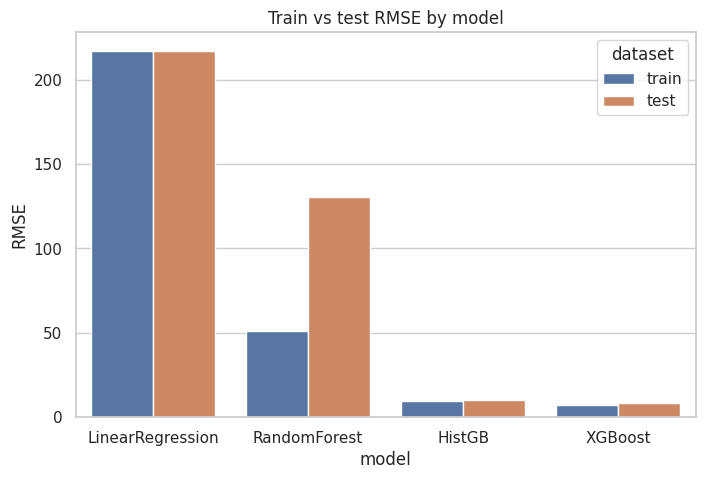

In [28]:
# Plot

plt.figure(figsize=(8, 5))
sns.barplot(
    data=rmse_comparison,
    x="model",
    y="RMSE",
    hue="dataset",
)
plt.title("Train vs test RMSE by model")
plt.ylabel("RMSE")
plt.show()

### Predicted vs true (parity plots) for each model

These show whether the model predictions match the actual `TotalAmount`.

Ideal behavior for regression, points lie on the diagonal line `y_true = y_pred`.

In [ ]:
def plot_pred_vs_true_2x2(plots, suptitle=None, savepath=None, dpi=300):
    """
    plots: exactly 4 items.
      Each item can be (y_true, y_pred, title)
      or dict: {"y_true": ..., "y_pred": ..., "title": ...}
    """

    if len(plots) != 4:
        raise ValueError("Provide exactly 4 plots for a 2x2 grid.")

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for ax, item in zip(axes, plots):
        if isinstance(item, dict):
            y_true = item["y_true"]
            y_pred = item["y_pred"]
            title = item.get("title", "")
        else:
            y_true, y_pred, title = item

        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        ax.scatter(y_true, y_pred, alpha=0.2, s=10)

        max_val = max(float(y_true.max()), float(y_pred.max()))
        min_val = min(float(y_true.min()), float(y_pred.min()))
        ax.plot([min_val, max_val], [min_val, max_val], linestyle="--")

        ax.set_xlabel("True TotalAmount")
        ax.set_ylabel("Predicted TotalAmount")
        ax.set_title(title)

    if suptitle:
        fig.suptitle(suptitle, y=1.02)

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    plt.show()
    return fig, axes


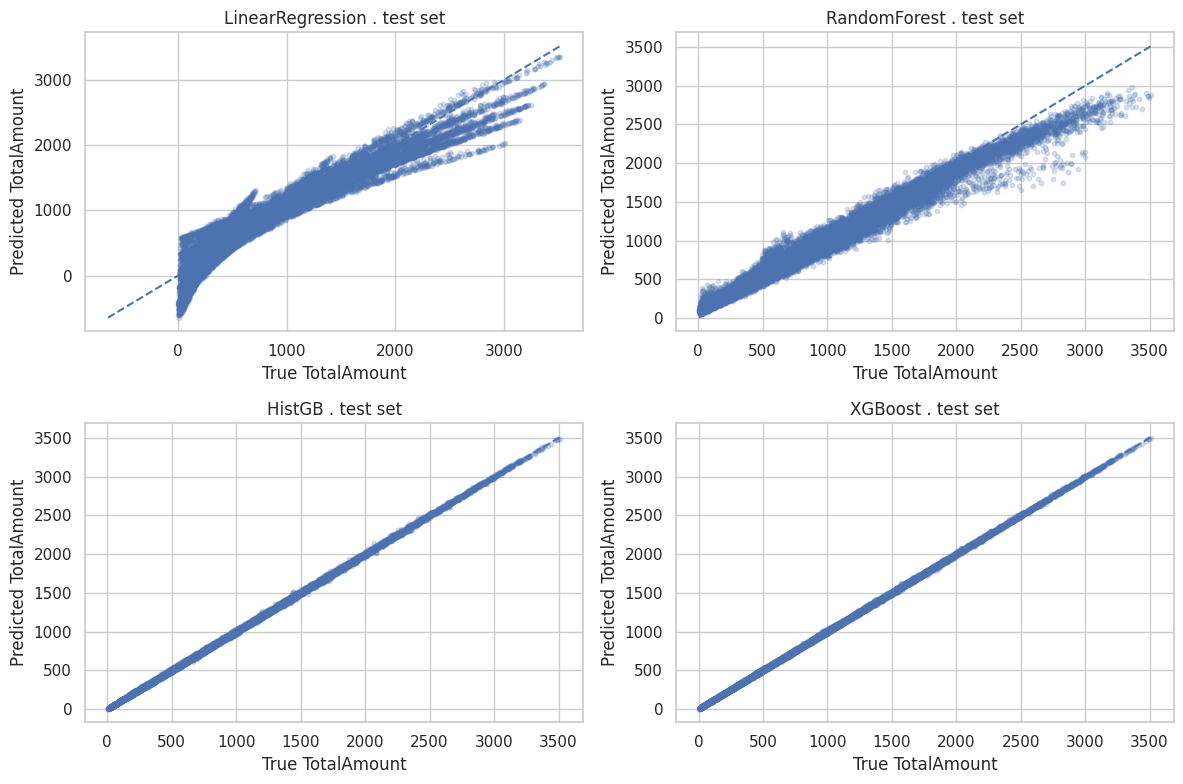

In [41]:
plot_pred_vs_true_2x2(
    [
        (y_test, y_pred_linreg_test, "LinearRegression . test set"),
        (y_test, y_pred_rf_test, "RandomForest . test set"),
        (y_test, y_pred_hgb_test, "HistGB . test set"),
        (y_test, y_pred_xgb_test, "XGBoost . test set"),
    ],
    savepath="pred_vs_true_2x2.png"
);


### Residual plots to see bias and heteroscedasticity

Residual = `y_true - y_pred`.

Plot residuals vs predicted value that shows whether errors are random or structured.

In [37]:


def plot_residuals_2x2(residual_plots, suptitle=None, savepath=None, dpi=300):  
    
    if len(residual_plots) != 4:
        raise ValueError("Give exactly 4 plots for a 2x2 grid.")

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for ax, item in zip(axes, residual_plots):
        if isinstance(item, dict):
            y_true = item["y_true"]
            y_pred = item["y_pred"]
            title = item.get("title", "")
        else:
            y_true, y_pred, title = item

        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        residuals = y_true - y_pred

        ax.scatter(y_pred, residuals, alpha=0.2, s=10)
        ax.axhline(0, color="red", linestyle="--", linewidth=1)
        ax.set_xlabel("Predicted TotalAmount")
        ax.set_ylabel("Residual (true - pred)")
        ax.set_title(title)

    if suptitle:
        fig.suptitle(suptitle, y=1.02)

    fig.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")

    plt.show()
    return fig, axes


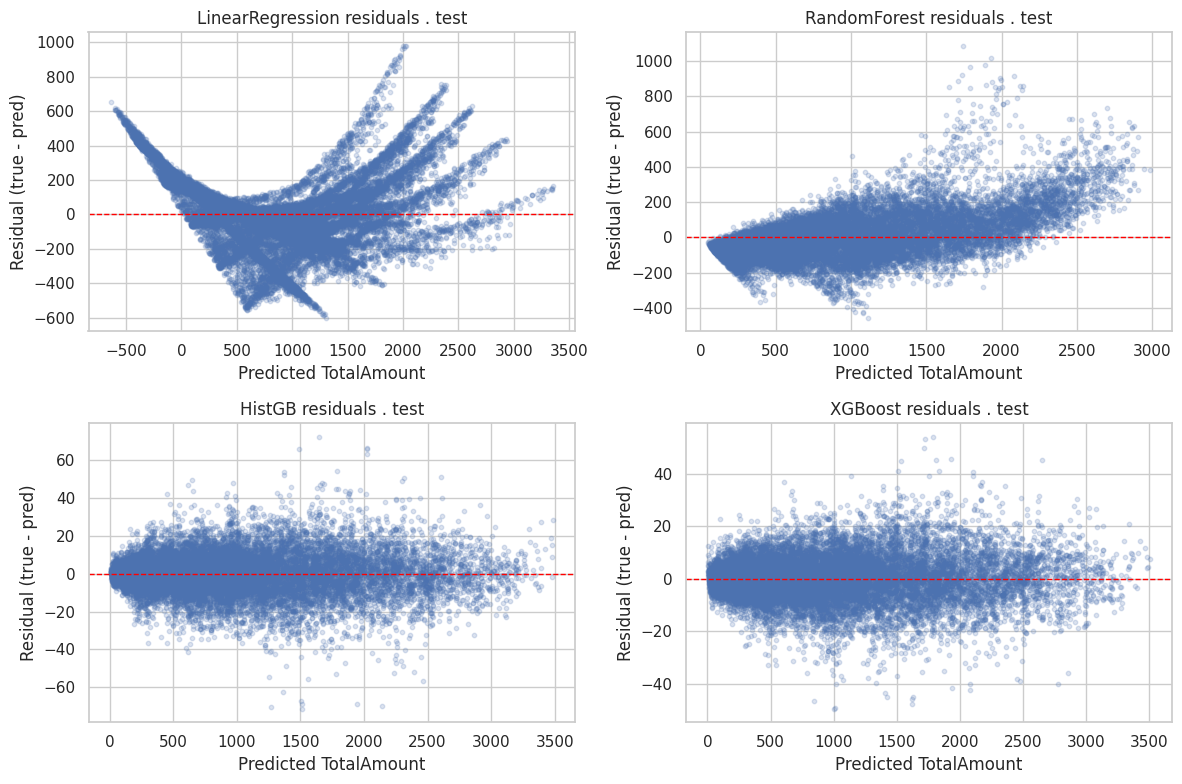

In [42]:
plot_residuals_2x2([
    (y_test, y_pred_linreg_test, "LinearRegression residuals . test"),
    (y_test, y_pred_rf_test, "RandomForest residuals . test"),
    (y_test, y_pred_hgb_test, "HistGB residuals . test"),
    (y_test, y_pred_xgb_test, "XGBoost residuals . test"),
], savepath="residuals_2x2.png");



### Residual distribution histograms

I'd like to see that how big the typical error is and whether residuals are symmetric.

In [46]:
# Plot

def plot_residual_hist(y_true, y_pred, title):
    residuals = y_true - y_pred

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.xlabel("Residual (true - pred)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

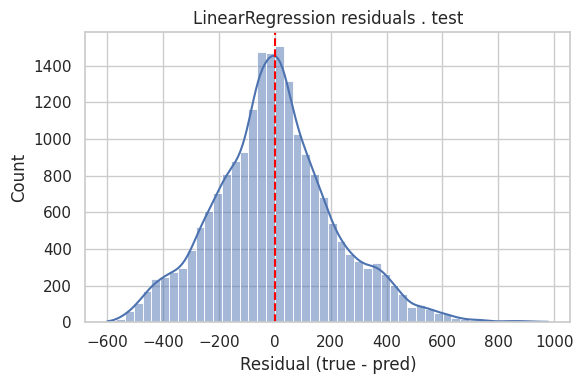

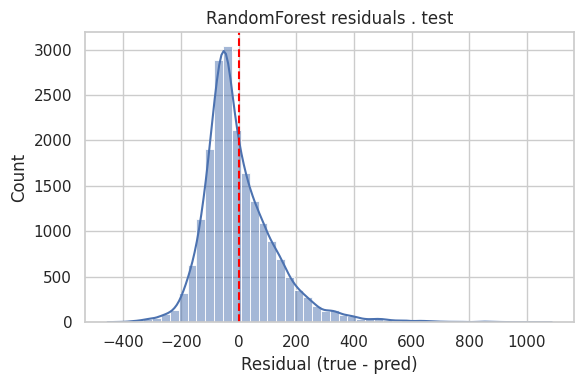

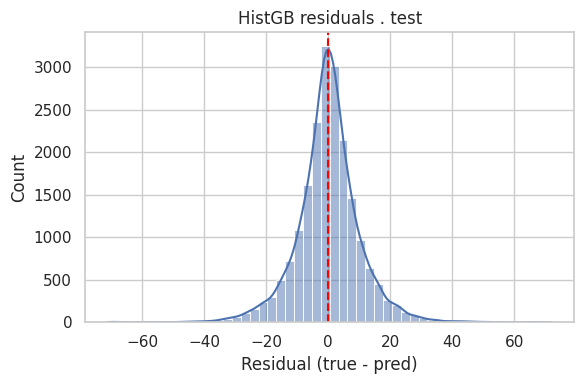

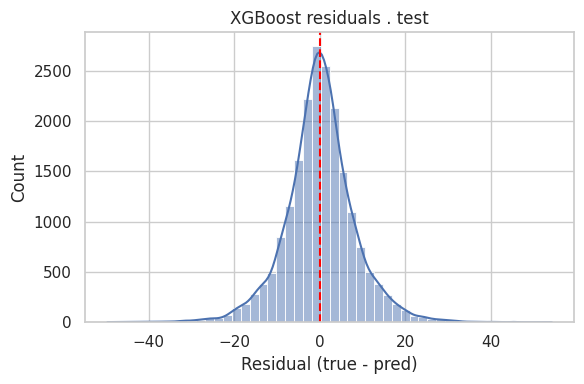

In [47]:
plot_residual_hist(y_test, y_pred_linreg_test, "LinearRegression residuals . test")
plot_residual_hist(y_test, y_pred_rf_test,    "RandomForest residuals . test")
plot_residual_hist(y_test, y_pred_hgb_test,   "HistGB residuals . test")
plot_residual_hist(y_test, y_pred_xgb_test,   "XGBoost residuals . test")